# Prerequisites

- Hashes pdf
- Merkle Damgard paradigm (optional)

# Theory

## The sponge construction

- https://crypto.stackexchange.com/questions/83258/what-is-the-sponge-construction-in-simple-terms

High level overview:
- **Absorbing phase**: Input is read and processed
- **Squeezing phase**: Output is produced

**Note**:
- Squeezing output can be modified from app to app: generating pseudorandom numbers, hashes, etc
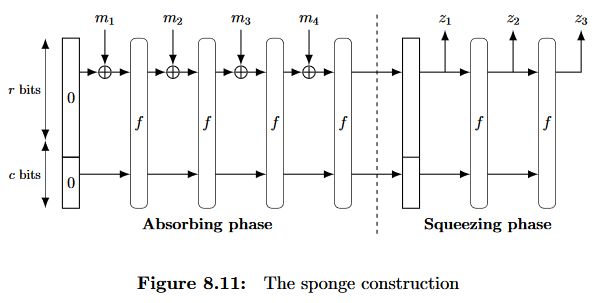

Let 
- $f:\{0,1\}^b \longrightarrow \{0,1\}^b$ be a permutation function
- $b = r + c$
    - $r$ = the *rate* of the sponge - block cipher block size
    - $c$ = the *capacity* of the sponge

**Speed/security tradeoff**
- Larger $r$ => faster evaluation
- Larger $c$ => Better security bounds -> $c$ is not seen by the attacker => sponge security

### Algorithm

- *Input:* message $M \in \{0,1\}^L$ and output length $v$
- *Output:*  $z$ 

1. *Pre Processing*
- Pad message $M => M||PB$
- Break message $M||PB$ into $r$-bit blocks $(m_1, ... m_s)$

2. *Absorbing stage*
- $h = 0^b$ - initialize with $0$
- for $i=1\rightarrow s \iff$ for each block 
    - $m_i' = m_i || 0^c \in \{0,1\}^b$
    - $h = f(h\oplus m_i')$
    
3. *Squeezing stage*
- $z_1 = h[0:r-1]$ - the first block
- for $i = 2 \rightarrow \lceil v/r \rceil \iff$ loop until we get the desired output 
    - $h = f(h)$
    - $z_i = h[0:r-1]$
- return $(z_1 || ...||z_{\lceil v/r \rceil})[0:v-1] \iff$ concatenate and truncate

## SHA3

$(m,v) \longrightarrow \boxed{\underset{\text{(add padding)}}{\text{pre-processing}} } \longrightarrow \underbrace{\boxed{\text{inner Keccak}}}_{\boxed{\text{absorbing phase}}\longrightarrow \boxed{\text{squeezing phase}}} \longrightarrow z$

### SHA3 uses the Keccak cipher (https://keccak.team/archives.html)
 

In Keccak 
- $b=r+c \in \{25, 50, 100, 200, 400, 800, 1600\}$
- $b=r + c = 25 \cdot 2^l \text{ for }  l \in \{1,...6\}$
- $b = 1600$ is used since it's the most efficient 
- Keccak permutation $f$ (or Keccak-$f[b]$) maps $b$-bit strings to $b$-bit strings

### The Keccak permutation function $f$

**Reminder**
> **Diffusion** means that if we change a single bit of the plaintext, then (statistically) half of the bits in the ciphertext should change, and similarly, if we change one bit of the ciphertext, then approximately one half of the plaintext bits should change

> **Confusion** means that each binary digit (bit) of the ciphertext should depend on several parts of the key, obscuring the connections between the two. 

- https://en.wikipedia.org/wiki/Confusion_and_diffusion

$f$ is made out of $n_r=12+2l$ rounds with 5 steps
- $\rightarrow \boxed{\theta}\rightarrow \boxed{\rho} \rightarrow \boxed{pi} \rightarrow \boxed{\chi} \rightarrow \boxed{\iota} \rightarrow$

#### The state

- We can visualise the state as a 3-dimensional array of elements 
- $A[5][5][w]$ with $w = 2^l$ where $A[x][y][z]$ is the bit in position $(x,y,z)$
- $x,y \in \mathbb{Z}_5  ; \ z \in \mathbb{Z}_w$
- the $\oplus$ and $+$ in $\mathbb{Z}_2$ are interchangable

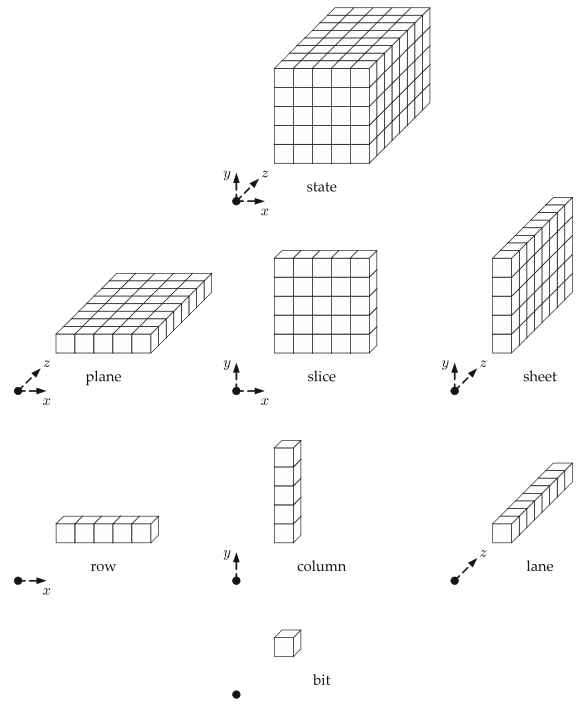

#### Step $\theta$

**Purpose and proprieties**
- Without it, the $f$ round function would not provide diffusion of any significance
- Linear
- Translation invariant in all directions

**Function**
$$A[x][y][z] = A[x][y][z] \oplus \underbrace{\sum_{y'=0}^4 A[x-1][y'][z]}_{\text{column parity}} \oplus \sum_{y'=0}^4 A[x+1][y'][z-1]$$

*Intuition*
- it adds to each bit $A[x][y][z]$ the bitwise sum ofthe parities of two columns: that of $A[x−1][·][z]$ and that of $a[x+1][·][z−1]$
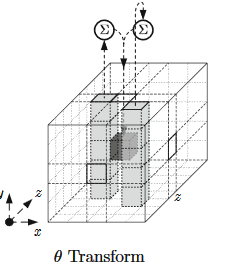

#### Step  $\rho$

**Purpose and proprieties**
- Provides inter slice dispersion
- Without it, diffusion between the slices would be very slow. 
- It is translation-invariant in the $z$-direction.

**Function**
$$A[x][y][z] = A[x][y][z - (t+1)(t+2)/2]$$

where $0<t<24$ and 
- $t = -1$ if $x,y = (0,0)$
- $
\begin{bmatrix}
0 & 1 \\
2 & 3
\end{bmatrix}^t \cdot
\begin{bmatrix}
0 \\
1
\end{bmatrix} = 
\begin{bmatrix}
x \\
y
\end{bmatrix} \in GF(5)^{2\times 2}$

*Intuition*
- Bitwise rotate each of the 25 words(lanes) by a different triangular number $(0, 1, 3, 6, 10, 15 ...)$

| |$x=3$|$x=4$|$x=0$|$x= 1$ |$x= 2$|
|-|-|-|-|-|-|
|$y=2$|153 | 231 | 3 | 10 | 171|
|$y=1$|55 | 276 | 36 | 300 | 6|
|$y=0$| 28 | 91 | 0 | 1 | 190
|$y=4$| 120 | 78| 210 | 66 | 253
|$y=3$| 21 | 136 | 105 | 45 | 15


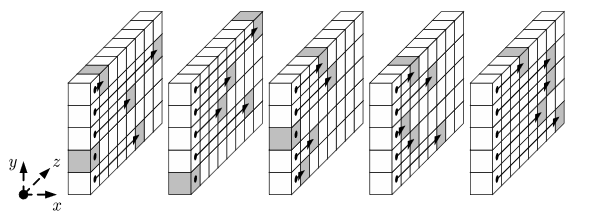

#### Step $\pi$

**Purpose and proprieties**
- Transposition of the lanes that provides dispersion aimed at long-term diffusion. 
- Without it, $f$ would exhibit periodic trails of low weight.
- Operates in a linear way on the coordinates (x,y):
- Translation invariant in the $z$-direction
- Many matrices can be chosen, here the hardware efficient one was chosen

**Function**
$$ A[x][y] = A[x'][y']$$

where 
- $\begin{bmatrix}
x \\
y
\end{bmatrix} =
\begin{bmatrix}
0 & 1\\
2 & 3
\end{bmatrix} \cdot
\begin{bmatrix}
x' \\
y'
\end{bmatrix}$

*Intuition*
- Fixed permutation over $z$-lanes
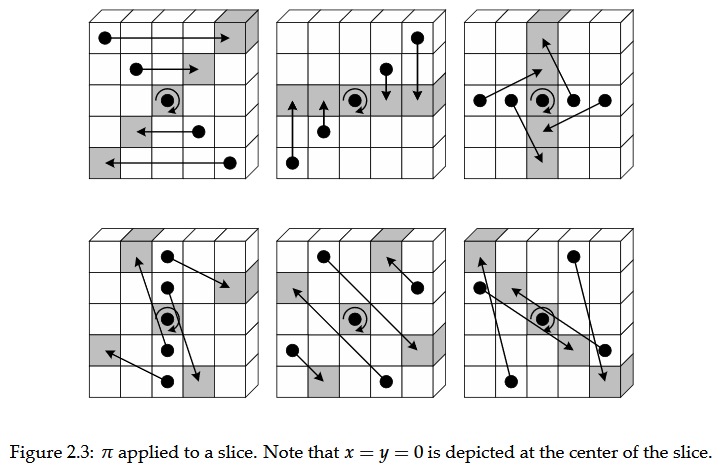

**Note**
- Rotation offets for $\rho$ and $\phi$ together:
| | x = 3 |	x = 4 |	x = 0 |	x = 1 |	x = 2|
|-|-|-|-|-|-|
y = 2 |	25 | 39 | 3 | 10 |	43
y = 1 |	55 | 20 | 36 | 44| 	6
y = 0 |	28 | 27 | 0 | 1 |	62
y = 4 |	56 | 14 | 18 | 2 |	61
y = 3 |	21 | 8 | 41 | 45 | 15

#### Step $\chi$

**Purpose and proprieties**
- The only non-linear mapping
- Operates on rows


**Function**
$$A[x] = A[x] \oplus (\bar{A}[x+1]) \ \& \ A[x+2]$$

*Intuition*
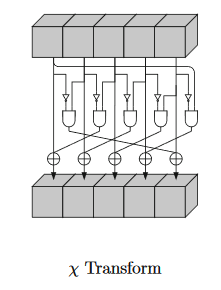

#### Step $\iota$

**Purpose and proprieties**
- Add round constants
- Distrupt symmetry
- Without it, the round function would be translation-invariant in the $z$-direction
    - all rounds would be the same making $f$ subject to attacks exploiting symmetry (Ex: slide attacks)
- The bits of the round constants are different from round to round and are taken as the output of a maximum-length LFSR. 

**Function**
$$ A = A + RC[i_r]$$


For other $b$ dimensions 
- https://keccak.team/files/Keccak-reference-3.0.pdf

# Code

https://keccak.team/keccak_specs_summary.html

In [50]:
import hashlib
import math
from Crypto.Util.number import long_to_bytes, bytes_to_long

In [272]:
m = b'secret_message'
h = hashlib.sha3_256(m).digest()
print(h, len(h), bin(bytes_to_long(h)))

b"N\x9a\x1e\xe4\x9f~\xd0-\xaa\x81b@\xd8\x14\xf0\xff\xd9\xb5\x9a\xc6&W\x03\x00\x13\xb4O\x80Z5\xae'" 32 0b100111010011010000111101110010010011111011111101101000000101101101010101000000101100010010000001101100000010100111100001111111111011001101101011001101011000110001001100101011100000011000000000001001110110100010011111000000001011010001101011010111000100111


In [33]:
def shr(x, n):
    return ((x & 0xffffffffffffffff) >>n) 
def rotr(x, n):
    return ((x>>n) | (x << (64 - n))) & 0xffffffffffffffff 

def split_blocks(x, block_size, block_nr):
    res = []
    mask = (1<<block_size)-1
    for i in range(block_nr):
        r = (x>>(block_size * i)) & mask
        res.insert(0, r) #last block should be last in list so we insert in front
    return res

In [232]:
# Keccak stuff

#Let A be a 2dim array 5x5 array 
def theta(A):
    C = [0] * 5
    D = [0] * 5
    res = [[0] * 5 for _ in range(5)]
    
    for x in range(4):
        C[x] = A[x][0] ^ A[x][1] ^ A[x][2] ^ A[x][3] ^ A[x][4] #first parity
        
    for x in range(4):
        D[x] = C[(x-1) % 5] ^ rotr(C[(x+1) % 5], 1) #second parity
        for y in range(4):
            res[x][y] = A[x][y] ^ D[x] #final result
            
    return res
            
rot_offset = [
    [0, 36, 3, 41, 18],
    [1, 44, 10, 45, 2],
    [62, 6, 43, 15, 61],
    [28, 55, 25, 21, 56],
    [27, 20, 39, 8, 14]
]
def rho_pi(A):
    res = [[0] * 5 for _ in range(5)]
    for x in range(5):
        for y in range(5):
            res[y][(2 * x + 3 * y) % 5] = rotr(A[x][y], rot_offset[x][y])
    return res
            
def chi(A):
    res = [[0] * 5 for _ in range(5)]
    for x in range(5):
        for y in range(5):
            res[x][y] = A[x][y] ^ ((0xffffffffffffffff ^ A[(x+1) % 5][y]) & A[(x+2) % 5][y])
    return res

def iota(A, RC):
    A[0][0] ^= RC
    return A

In [275]:
class SHA3_256():
    def __init__(self):
        #parameters
        self.RC =[ 0x0000000000000001, 0x0000000000008082, 0x800000000000808A, 
        0x8000000080008000,0x000000000000808B, 0x0000000080000001, 0x8000000080008081, 0x8000000000008009,
        0x000000000000008A, 0x0000000000000088,0x0000000080008009,0x000000008000000A,0x000000008000808B,0x800000000000008B,
        0x8000000000008089, 0x8000000000008003, 0x8000000000008002,  0x8000000000000080, 0x000000000000800A, 0x800000008000000A,
        0x8000000080008081, 0x8000000000008080, 0x0000000080000001, 0x8000000080008008]
        self.word_size = 64
        self.l = 6
        self.b = 1600 #25 * self.word_size
        self.r = 512 #block size
        self.c = self.b-self.r
        self.v = 256
        self.n_r = 12 + 2 * self.l

    
    def hash(self, M_bytes):
        #pre processing
        M = bytes_to_long(M_bytes)
        M_pad = self.pad2(M, self.r)
        s = (len(long_to_bytes(M_pad)) * 8 // self.r) #number of blocks
        ms = split_blocks(M_pad, self.r, s) #split in 512b blocks
        
        res = self.sponge(ms) #sponge
        return long_to_bytes(res)
    
    def sponge(self, ms, v = 256):
        
        # Absorbing phase
        S = [[0] * 5 for _ in range(5)] #=initial state
        for mi in ms:
            mi_ = mi << self.c #append 0
            mis = split_blocks(mi_, self.word_size, 25) #split into 25 words of size 64b
            for x in range(5):
                for y in range(5):
                    if x + 5 * y < self.r / self.word_size: #???
                        S[x][y] = S[x][y] ^ mis[x + 5*y] 
            S = self.keccak(S)
        
        # Squeezing phase
        z = 0
        for i in range(math.ceil(v/self.r)):
            for x in range(5):
                for y in range(5):
                    if x + 5 * y < self.r / self.word_size: #???
                        z  = (z << self.word_size) | S[x][y]
            S = self.keccak(S)
        
        return z >> (len(long_to_bytes(z)) * 8  - v) #???
        return z & ((1<<v) - 1) #???
    
    
    '''Keccak stuff'''
    def keccak(self, A, n_r = 24):
        for i in range(0, n_r):
            A = self.keccak_round(A, self.RC[i])
        return A
    
    
    def keccak_round(self, A, round_constant):
        res = theta(A)
        res = rho_pi(res)
        res = chi(res)
        res = iota(res, round_constant)
        return res
        
    def pad(self, M, block_size = 512):
        #long_to_bytes(bytes_to_long(''.encode())) has length 1 instead of 0
        if M != 0:
            #pad to a multiple of 8
            M_bits = M.bit_length()
            if M_bits % 8:
                M_bits = M_bits + 8 - (M_bits % 8) 
            #equivalent to this
            #M_bits= len(long_to_bytes(M)) * 8 #this is better for shorter messages
        else:
            M_bits = 0
        
        res = (M << 1) | 1 
        last_block_space = block_size - M_bits % block_size - 1
        #make new block if necessary
        if last_block_space < 2:
            last_block_space+=block_size #512
        res = (res<<last_block_space) | 1 # add the final 1
        return res
    
    def pad2(self, M, block_size=512):
        M_bits = len(long_to_bytes(M)) * 8
        j = (-M_bits-2) % block_size
        return (M << (j+2)) | (1<<(j+1)) | 1
        

In [276]:
sha3_256 = SHA3_256()
m = b'secret_message'
h = sha3_256.hash(m)
print(h, len(h), bin(bytes_to_long(h)))

[[6491371404798607854, 6557560228882883745, 14774963741050424199, 7207184372104560640, 15884978047809325260], [6043370165400314715, 21532993688455808, 6842943192454479190, 863124313942064821, 18092089416679284553], [13881681136303808492, 10273387228859970918, 13054698722814312601, 7400920698468314113, 0], [6065753635403437831, 6007735297164044839, 7783254237278145294, 7751355323547574705, 10124488599321029404], [414898552834171416, 0, 1365717146225161296, 214042399706726149, 2559496495904617489]]
b'Z\x15\xfb\xe6`&A\xee[\x01"H\xe3\xcb$\xa1S\xde]%r\xe1#[\x00L\x80$\xc7\xc0J\x80\xc0\xa5\xa3q\xf6\xa1\x1f\xec\x8e\x92gA\x00;\xb5fT-\xe2\xcb-A\x97\x07\x05\xc2\x04\t\x1b\x81"\x18' 64 0b1011010000101011111101111100110011000000010011001000001111011100101101100000001001000100100100011100011110010110010010010100001010100111101111001011101001001010111001011100001001000110101101100000000010011001000000000100100110001111100000001001010100000001100000010100101101000110111000111110110101000010001111111101

# Resources

- https://www.youtube.com/watch?v=JWskjzgiIa4&t
- https://en.wikipedia.org/wiki/Sponge_function
- https://tinycrypt.wordpress.com/2017/09/24/keccak-permutation-function/ - keccak implementation
- https://crypto.stackexchange.com/questions/38050/can-we-exchange-the-permutation-of-a-sponge-construction
- https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.202.pdf